In [1]:
# Code based on: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
# and: https://github.com/lcampillos/Medical-NER/blob/master/bert_ner.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

In [4]:
# Load the data

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("/content/drive/MyDrive/.../ES-manual-sents-number.tsv",sep=" ",engine="python",quoting=3)
data.tail(10)

,sentence,text,labels
44599,1615,Lord,B-LEGAL_PROFESSIONAL
44600,1615,Rodger,I-LEGAL_PROFESSIONAL
44601,1615,.,O
44602,1616,Desestimó,O
44603,1616,el,O
44604,1616,recurso,O
44605,1616,de,O
44606,1616,la,O
44607,1616,demandante,O
44608,1616,.,O


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Split the dataset:
# Spanish corpus of 44 texts from ECHR (automatic translations) with manual annotations

tr_data, val_data = train_test_split(data, random_state=42, test_size=0.2, shuffle=False)

In [7]:
tr_data.tail(10)

,sentence,text,labels
35677,1272,el,O
35678,1272,artículo,O
35679,1272,24,O
35680,1272,del,O
35681,1272,Reglamento,O
35682,1272,del,O
35683,1272,Tribunal,O
35684,1272,.,O
35685,1273,El,O
35686,1273,demandante,O


In [8]:
test_data, val_data = train_test_split(val_data, random_state=42, test_size=0.5, shuffle=False)

In [9]:
test_data.tail(10)

,sentence,text,labels
40138,1459,la,O
40139,1459,reclamación,O
40140,1459,",",O
40141,1459,alegando,O
40142,1459,que,O
40143,1459,no,O
40144,1459,se,O
40145,1459,organizaban,O
40146,1459,actividades,O
40147,1459,educativas,O


In [10]:
val_data.tail(10)

,sentence,text,labels
44599,1615,Lord,B-LEGAL_PROFESSIONAL
44600,1615,Rodger,I-LEGAL_PROFESSIONAL
44601,1615,.,O
44602,1616,Desestimó,O
44603,1616,el,O
44604,1616,recurso,O
44605,1616,de,O
44606,1616,la,O
44607,1616,demandante,O
44608,1616,.,O


In [11]:
print(len(tr_data))
print(len(val_data))
print(len(test_data))

35687
4461
4461


In [12]:
class ProcessSentences(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["text"].values.tolist(),
                                                           s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
sentences_data_train = ProcessSentences(tr_data)
sentences_data_dev = ProcessSentences(val_data)
sentences_data_test = ProcessSentences(test_data)

In [14]:
sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in sentences_data_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test.sentences]
sentences_dev[0][:10] # First 10 elements of sentence 1

['para', 'los', 'reclusos', 'peligrosos', '.']

In [15]:
# Show labels
labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in sentences_data_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test.sentences]
print(labels_dev[0][:10]) # First 10 labels of sentence 1

['O', 'O', 'O', 'O', 'O']


In [16]:
# Label values
tag_values = list(set(tr_data["labels"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

Apply mBERT

In [17]:
!pip install torch

In [18]:
# Prepare the sentences and labels

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

torch.__version__

'2.1.0+cu121'

In [19]:
# Bert supports sequences of up to 512 tokens

MAX_LEN = 250
bs = 32

In [20]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
!nvidia-smi

Tue Jan  2 07:53:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
model_checkpoint = 'bert-base-multilingual-cased'

In [22]:
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [23]:
# Function to tokenize and preserve labels
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize each word and count number of its subwords
        # We force conversion to string to avoid errors with float elements
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # The tokenized word is added to the resulting tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # The same label is added to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [24]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [25]:
tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

In [26]:
tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [27]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [28]:
# Padding of sentences according to desired input length
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [29]:
# Paddding of labels with regard to input length
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [30]:
# Create the attention mask to ignore the padded elements in the sequences during training, development and testing
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [31]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)

In [32]:
# We define the dataloaders.
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

Fit mBERT for named entity recognition

In [33]:
# Setup the Bert model for finetuning

import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.35.2'

In [34]:
model = BertForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Pass the model parameters to the GPU

model.cuda();

In [36]:
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
# Import a scheduler to reduce the learning rate
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 4
epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [38]:
# Define some metrics

!pip install seqeval==0.0.12

  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7413 sha256=3b7faca5a5d820a0b4855b83494aa27f00911993b9e0abf53c6e954df8eb9f13
  Stored in directory: /root/.cache/pip/wheels/6c/6c/fc/7076d687ba54f32c7be7eaaded97df359ef3c8fee08a2d4efc
Successfully built seqeval


In [39]:
import seqeval
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

In [40]:
%%time
# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []

for _ in range(epochs):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))


    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Development Accuracy: {}".format(accuracy_score(pred_tags, dev_tags)))
    print("Development F1-Score: {}".format(f1_score(pred_tags, dev_tags)))
    print("Development Precision: {}".format(precision_score(pred_tags, dev_tags)))
    print("Development Recall: {}".format(recall_score(pred_tags, dev_tags)))
    print("Development classification report:\n{}".format(classification_report(pred_tags, dev_tags))) # digits=4
    print()

Average train loss: 0.4837852860800922
Development loss: 0.05787624977529049
Development Accuracy: 0.8902920284135754
Development F1-Score: 0.20588235294117646
Development Precision: 0.15328467153284672
Development Recall: 0.31343283582089554
Development classification report:
                    precision    recall  f1-score   support

LEGAL_PROFESSIONAL       0.09      0.05      0.06        20
              DATE       0.44      0.39      0.41        94
               LOC       0.06      0.20      0.09        20

         micro avg       0.15      0.31      0.21       134
         macro avg       0.33      0.31      0.31       134


Average train loss: 0.040837792796082795
Development loss: 0.03602797575294971
Development Accuracy: 0.925414364640884
Development F1-Score: 0.4972776769509982
Development Precision: 0.5
Development Recall: 0.49458483754512633
Development classification report:
                    precision    recall  f1-score   support

              DATE       0.80      

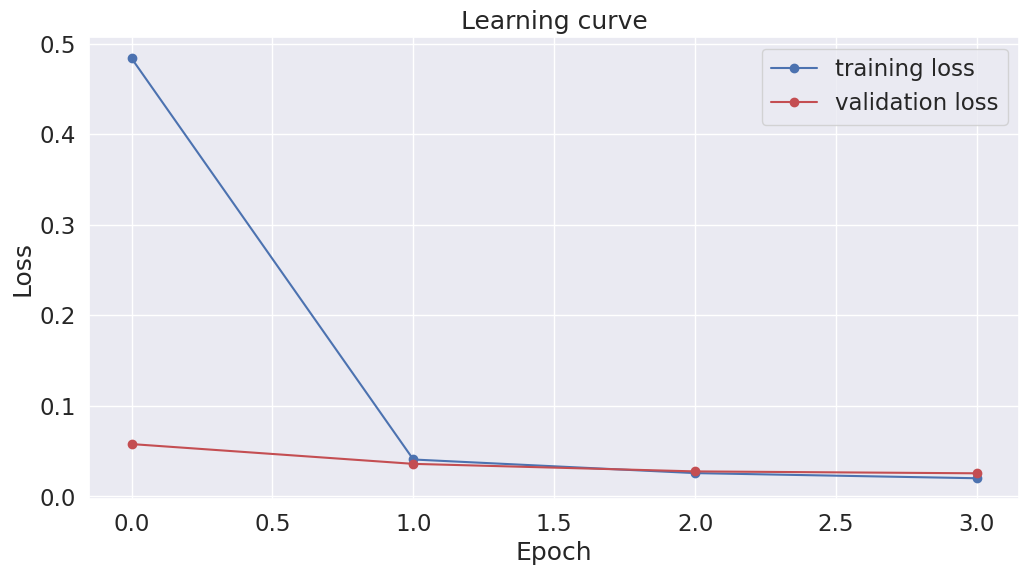

In [41]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [42]:
# Apply the model to the test set
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate predictions.
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    # Transfer logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)

    # Calculate the accuracy for this batch of test sentences
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
print("Test Accuracy: {}".format(accuracy_score(pred_tags, test_tags),digits=4))
print("Test F1-Score: {}".format(f1_score(pred_tags, test_tags)))
print("Test Precision: {}".format(precision_score(pred_tags, test_tags)))
print("Test Recall: {}".format(recall_score(pred_tags, test_tags)))
print("Test classification report: {}".format(classification_report(pred_tags, test_tags))) #digits=4
print()

Test Accuracy: 0.9758078756842663
Test F1-Score: 0.768060836501901
Test Precision: 0.792156862745098
Test Recall: 0.7453874538745388
Test classification report:                     precision    recall  f1-score   support

              DATE       0.96      0.97      0.96        88
               LOC       0.81      0.57      0.67       122
LEGAL_PROFESSIONAL       0.71      0.71      0.71        17
       NATIONALITY       0.75      1.00      0.86         6
              CODE       0.69      0.82      0.75        11
          QUANTITY       0.62      0.79      0.70        19
               ORG       0.11      0.25      0.15         4
               PER       0.67      1.00      0.80         4

         micro avg       0.79      0.75      0.77       271
         macro avg       0.82      0.75      0.77       271




In [43]:
# Save model

path = '/content/drive/MyDrive/.../'

model.save_pretrained(path)
tokenizer.save_pretrained(path)

In [45]:
path = '/content/drive/MyDrive/.../pytorch_model.bin'

torch.save(model, path)

In [46]:
# Apply the model to a new sentence

test_sentence = """
George Washington fue a Washington.
"""

In [47]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [48]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [49]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [50]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	George
B-LOC	Washington
O	fue
O	a
O	Washington
O	.
PAD	[SEP]


In [51]:
# Apply the model to a new sentence

test_sentence = """
El Sr. Pierson es inglés y viajó a Madrid el 13 de julio de 2004 a las 5 p.m.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

B-DATE	[CLS]
O	El
I-PER	Sr
I-PER	.
I-PER	Pierson
O	es
O	inglés
O	y
O	viajó
O	a
B-LOC	Madrid
B-DATE	el
I-DATE	13
I-DATE	de
I-DATE	julio
I-DATE	de
I-DATE	2004
O	a
O	las
I-DATE	5
I-DATE	p
B-DATE	.
I-DATE	m
B-DATE	.
PAD	[SEP]


In [52]:
# Apply the model to a new sentence

test_sentence = """
El número identificativo es 1234/56P.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	El
O	número
O	identificativo
O	es
O	1234
O	/
I-PER	56P
O	.
PAD	[SEP]


In [53]:
# Apply the model to a new sentence

test_sentence = """
El número identificativo es 123456P.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	El
O	número
O	identificativo
O	es
B-CODE	123456P
O	.
PAD	[SEP]


In [54]:
# Apply the model to a new sentence

test_sentence = """
La Sra. García pagó 500 euros a su médico por una cirugía estética facial.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-PER	.
I-PER	García
O	pagó
O	500
O	euros
O	a
O	su
O	médico
O	por
O	una
O	cirugía
O	estética
O	facial
O	.
PAD	[SEP]


In [55]:
# Apply the model to a new sentence

test_sentence = """
El Sr. Laurence tiene 100 libras (GBP).
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	El
B-LEGAL_PROFESSIONAL	Sr
I-LEGAL_PROFESSIONAL	.
I-LEGAL_PROFESSIONAL	Laurence
O	tiene
B-QUANTITY	100
B-QUANTITY	libras
O	(
I-ORG	GBP
O	)
O	.
PAD	[SEP]


In [56]:
# Apply the model to a new sentence

test_sentence = """
La Sra. Gerania trabaja en la Organización Mundial de la Salud.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-PER	.
I-PER	Gerania
O	trabaja
O	en
O	la
O	Organización
O	Mundial
O	de
O	la
O	Salud
O	.
PAD	[SEP]


In [57]:
# Apply the model to a new sentence

test_sentence = """
La Sra. Gerania trabaja en la agencia Caramba.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-PER	.
I-PER	Gerania
O	trabaja
O	en
O	la
O	agencia
B-ORG	Caramba
O	.
PAD	[SEP]


In [58]:
# Apply the model to a new sentence

test_sentence = """
La Sra. Gerania es General y trabaja en la Prisión Militar de Hamburgo.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-LEGAL_PROFESSIONAL	.
I-LEGAL_PROFESSIONAL	Gerania
O	es
O	General
O	y
O	trabaja
O	en
O	la
O	Prisión
O	Militar
O	de
B-LOC	Hamburgo
O	.
PAD	[SEP]


In [59]:
# Apply the model to a new sentence

test_sentence = """
La Sra. Gerania es jueza y trabaja en el Tribunal Marcial de Helsinki.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-LEGAL_PROFESSIONAL	.
I-LEGAL_PROFESSIONAL	Gerania
O	es
O	jueza
O	y
O	trabaja
O	en
O	el
O	Tribunal
O	Marcial
O	de
B-LOC	Helsinki
O	.
PAD	[SEP]


In [60]:
# Apply the model to a new sentence

test_sentence = """
La Sra. Gerania tiene 40 años y trabaja en el Tribunal Superior de Noruega.
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	La
I-PER	Sra
I-PER	.
I-PER	Gerania
O	tiene
B-QUANTITY	40
O	años
O	y
O	trabaja
O	en
O	el
O	Tribunal
O	Superior
O	de
B-LOC	Noruega
O	.
PAD	[SEP]
